In [45]:
import torch, torchvision
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import copy
import csv

In [1]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-fs-prebuilt' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'


In [2]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2022-05-12 00:36:22--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.39.144
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2022-05-12 00:36:24--  https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?Y4uoNYrXq-XWg9XSdeWqSA6hzM3_N65hClt1GiGTm5bP6J5qhiGI1nwYETurPVjFORNVApUTjDAAYqaFll3w6FDapXGaG-RhaBaR6cAY8-nCC

In [7]:
!nvidia-smi

Thu May 12 00:41:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
import torch
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False.

True

In [10]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask 

In [12]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded

In [13]:
augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

In [15]:
train_dataset = PascalVOCSearchDataset('.',download = True, transform = augs)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./VOCtrainval_11-May-2012.tar to .


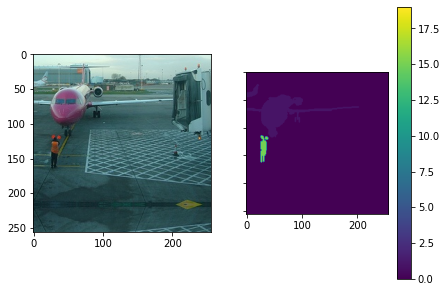

In [16]:
img,lbl = train_dataset[0]
fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
ax = ax.ravel()

ax[0].imshow(img.permute(1,2,0))
lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
plt.colorbar(lbl_plot,ax = ax[1])
plt.show()

In [18]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [19]:
model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

In [20]:
optim = torch.optim.AdamW(model.parameters(), lr = 2e-3, weight_decay = 1e-5)

In [21]:
dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)

In [22]:
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

In [23]:
model.cuda()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),

In [24]:
r_losses = []
rloss = 0
next_desc = "first epoch"
for epoch in range(5):
  
  for img,lbl in tqdm(dataloader, desc = next_desc):
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    loss = crit(predict, lbl)
    loss.backward()
    optim.step()
    optim.zero_grad()
    rloss += loss.detach().cpu().item() / len(dataloader)
  r_losses+= [rloss]
  next_desc = f"Epoch: [{epoch+1}], previous rloss: [{rloss:.3f}]"
  rloss = 0

Epoch: [4], previous rloss: [0.816]: 100%|██████████| 183/183 [02:59<00:00,  1.02it/s]


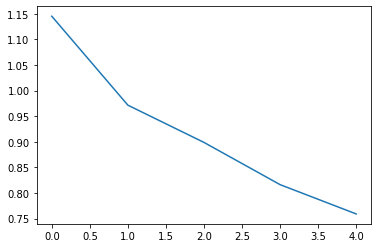

In [25]:
plt.plot(r_losses)

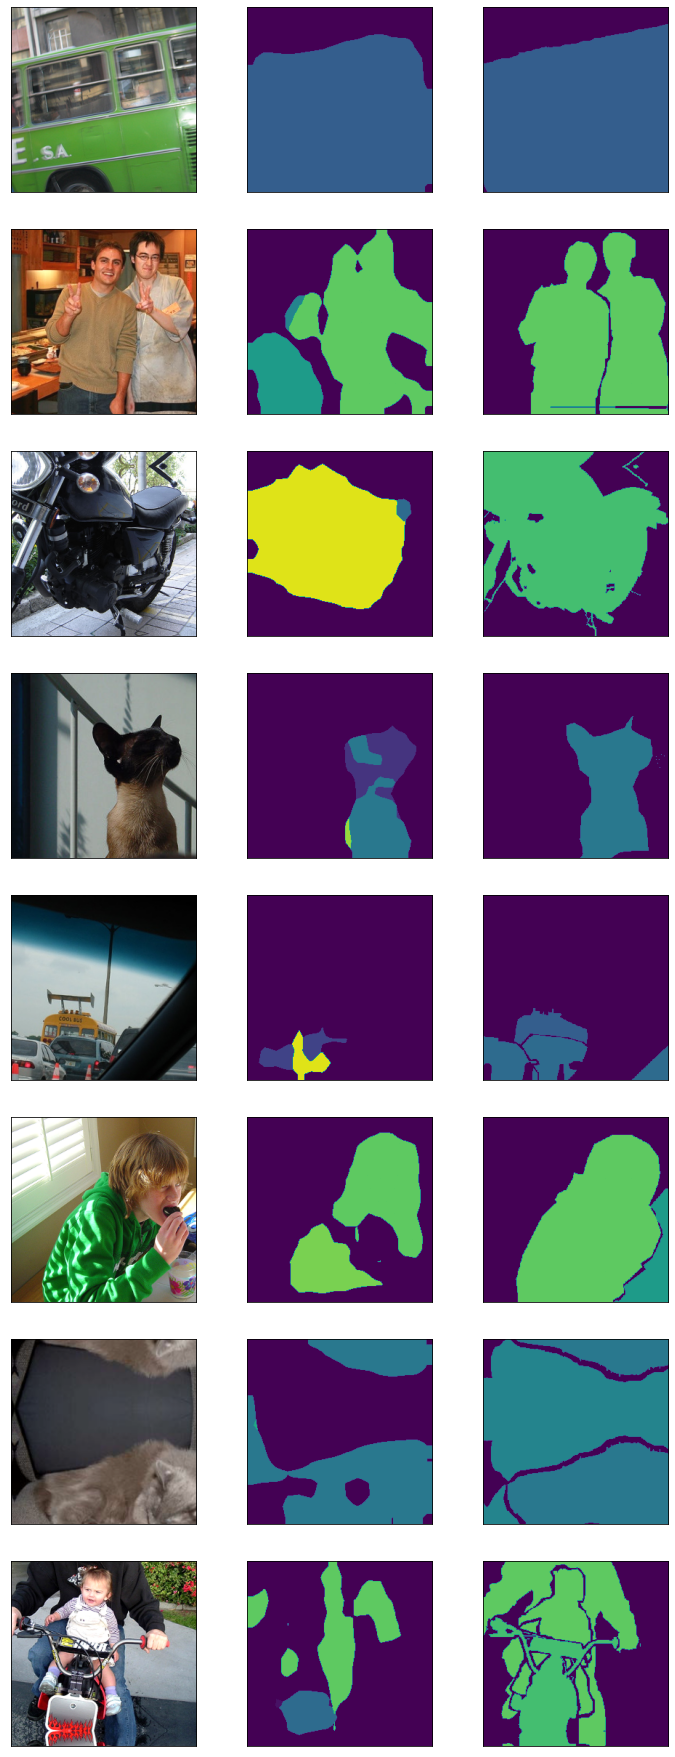

In [26]:
fig,axes = plt.subplots(len(lbl), 3, figsize = (12, len(lbl) * 4))
for idc, (simg, spred, slbl) in enumerate(zip(img.detach().cpu(), predict.detach().cpu().softmax(1), lbl.detach().cpu())):
  axes[idc, 0].imshow(simg.permute(1,2,0))
  axes[idc, 1].imshow(spred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  axes[idc, 2].imshow(slbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
[ax.get_xaxis().set_visible(False) for ax in  fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.show()

#### Задание 
1. Написать валидацию на каждой эпохе
2. Написать расчет метрики IoU, (расчет должен быть векторным, выход тензор формы [BxC] где B - плоскость батча, С - класса)
3. Написать расчет метрики MIoU на основе IoU. Также представить IoU в среднем по датасету на последней валидации в развертке по классам.
(пользоваться уже написанным IoU)
5. Обучить модель на приемлемое качество (хотя бы 25% MIoU на валидации). (Отбирать лучшее качество на валидации, отдельные запуски логировать в csv табличку: номер пуска: MIoU в среднем по классам)
4. Отобрать по 2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей по качеству: картинки, при ранжировании по качеству попадающие в первые 10%,  в промежутке между 15% - 25%, и 45% - 55%. (пользоваться уже написанным IoU)
5. Отобрать лучшую по качеству IoU картинку по трем выбранным классам.
6. Посчитать таблицу IoU в развертке по кадому классу для лучшей модели.
* Таблицы, картинки, и ipynb-тетрадь собрать в архив. Картинки можно просто отобразить в тетради, уже без необходимости сохранения, как и таблицы. (Кроме таблицы с запусками, её приложить в архив).
** При обучении можете попробовать другие ФО, или аугментации. Модель тоже можете поменять. 

In [38]:
size_fix = Compose([
                 PadIfNeeded(448,448),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

train_dataset = PascalVOCSearchDataset('.', image_set = "train",download = True, transform = augs)
test_dataset = PascalVOCSearchDataset('.', image_set = "val",download = True, transform = size_fix)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [39]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 4)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle = True, num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [40]:
r_losses = []
val_accuracy = []
train_accuracy = []
rloss = 0
val_desc = "val"
next_desc = "train"

for epoch in range(5):
    #обучение
    model.train()
    for img,lbl in tqdm(train_dataloader, desc = next_desc):
        img = img.cuda()
        lbl = lbl.cuda()
        predict = model(img)['out']
        loss = crit(predict, lbl)
        loss.backward()
        optim.step()
        optim.zero_grad()
        rloss += loss.detach().cpu().item() / len(train_dataloader)
    r_losses+= [rloss]
    next_desc = f"train Epoch: [{epoch+1}], loss: [{rloss:.3f}], accuracy: {1-rloss:.3f}"
    train_accuracy.append(1-rloss)
    rloss = 0
    #валидация
    model.eval()
    for img,lbl in tqdm(test_dataloader, desc = val_desc):
        img = img.cuda()
        lbl = lbl.cuda()
        predict = model(img)['out']
        loss = crit(predict, lbl)
        rloss += loss.detach().cpu().item() / len(test_dataloader)
    val_desc = f"val Epoch: [{epoch+1}], loss: [{rloss:.3f}], accuracy: {1-rloss:.3f}"
    val_accuracy.append(1-rloss)
    rloss = 0

train:   0%|          | 0/183 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
val Epoch: [4], loss: [0.846], accuracy: 0.154: 100%|██████████| 182/182 [03:08<00:00,  1.03s/it]


In [41]:
def compute_iou(predict, lbl):
    a = []
    for p, l in zip(predict, lbl):
        s = []
        for k in range(len(lbl[0])):
            result1 = p[0][k]
            result2 = l[0][k]
            intersection = np.logical_and(result1, result2)
            union = np.logical_or(result1, result2)
            iou = np.sum(intersection) / np.sum((union + 1e-8))
            s.append(iou)
        a.append(s)
    a = np.array(a)
    return a

def compute_mean_iou(predict, lbl):
    iou_score = compute_iou(predict, lbl)
    iou_score = np.mean(iou_score)
    return iou_score

In [42]:
for img,lbl in test_dataloader:
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    predict = predict.cpu().detach().numpy()
    #print('predict: ', predict)
    lbl = lbl.cpu().detach().numpy()
    iou = compute_iou(predict, lbl)
    print('IoU shape is', iou.shape)
    print('meanIoU', compute_mean_iou(predict, lbl))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


IoU shape is (8, 21)
meanIoU 0.7610211977469307


In [46]:
line = ['0', 'best_val']
with open('launches.csv', 'a') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(line)

In [47]:
def log_in_csv(val):
    with open('launches.csv', 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            n = row[0]
    nn = int(n) + 1
    line = [nn, val]
    with open('launches.csv', 'a') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(line)

In [50]:
r_losses = []
val_accuracy = []
train_accuracy = []
val_miou = 0
all_val_miou = []
best_val_miou = 0
rloss = 0
val_desc = "val"
next_desc = "train"

for epoch in range(5):
    #обучение
    model.train()
    for img,lbl in tqdm(train_dataloader, desc = next_desc):
        img = img.cuda()
        lbl = lbl.cuda()
        predict = model(img)['out']
        loss = crit(predict, lbl)
        loss.backward()
        optim.step()
        optim.zero_grad()
        rloss += loss.detach().cpu().item() / len(train_dataloader)
    r_losses+= [rloss]
    next_desc = f"train Epoch: [{epoch+1}], loss: [{rloss:.3f}]"
    train_accuracy.append(1-rloss)
    rloss = 0
    #валидация
    model.eval()
    for img,lbl in tqdm(test_dataloader, desc = val_desc):
        img = img.cuda()
        lbl = lbl.cuda()
        predict = model(img)['out']
        loss = crit(predict, lbl)
        rloss += loss.detach().cpu().item() / len(test_dataloader)
        predict = predict.cpu().detach().numpy()
        lbl = lbl.cpu().detach().numpy()
        t = compute_mean_iou(predict, lbl)
        if (best_val_miou < t):
            best_val_miou = t
        val_miou += t
        all_val_miou.append(t)
    val_miou = val_miou / len(test_dataloader)
    val_desc = f"val Epoch: [{epoch+1}], loss: [{rloss:.3f}], MIoU: {val_miou}"
    val_accuracy.append(1-rloss)
    rloss = 0
log_in_csv(val_miou)
print("best val miou:", best_val_miou)

train:   0%|          | 0/183 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
train Epoch: [1], loss: [0.580]: 100%|██████████| 183/183 [03:16<00:00,  1.07s/it]
val Epoch: [1], loss: [0.791], MIoU: 0.8175339389972792: 100%|██████████| 182/182 [03:14<00:00,  1.07s/it]
train Epoch: [2], loss: [0.610]: 100%|██████████| 183/183 [03:15<00:00,  1.07s/it]
val Epoch: [2], loss: [0.998], MIoU: 0.8286037551844947: 100%|██████████| 182/182 [03:10<00:00,  1.05s/it]
train Epoch: [3], loss: [0.574]: 100%|██████████| 183/183 [03:13<00:00,  1.06s/it]
val Epoch: [3], loss: [0.819], MIoU

best val miou: 0.9999999899999997


In [51]:
all_val_miou = torch.tensor(all_val_miou)

In [52]:
def plot_images(indx):
    img, lbl = test_dataset[indx]
    
    img = img.reshape(1, 3, 256, 256)
    img = img.cuda()
    pred = model(img)['out']
    pred = pred.detach().cpu()[0]
    
    fig,axes = plt.subplots(1, 3, figsize = (12, 1 * 4))
    axes[0].imshow(img.reshape(3, 256, 256).detach().cpu().permute(1,2,0))
    axes[1].imshow(pred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
    axes[2].imshow(lbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)

def quantile(ql, qr):
    mask = torch.logical_and((all_val_miou.quantile(ql) <= all_val_miou), (all_val_miou < all_val_miou.quantile(qr))) 
    ii = mask.nonzero()[:2]

    for indx in ii:
        plot_images(indx)

< 10%


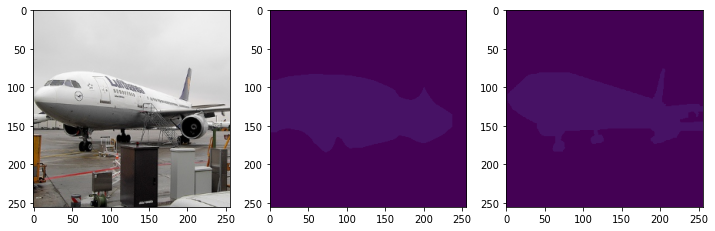

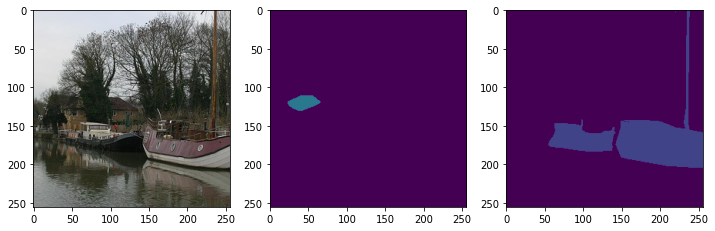

In [53]:
print('< 10%')
quantile(0, 0.1)

[15%,25%]


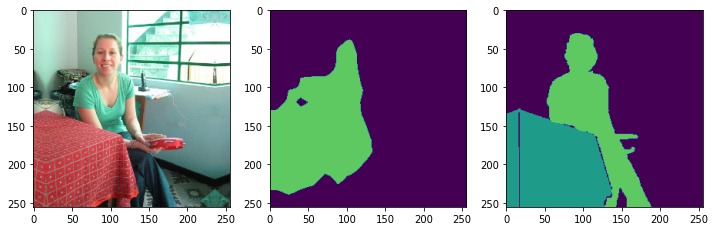

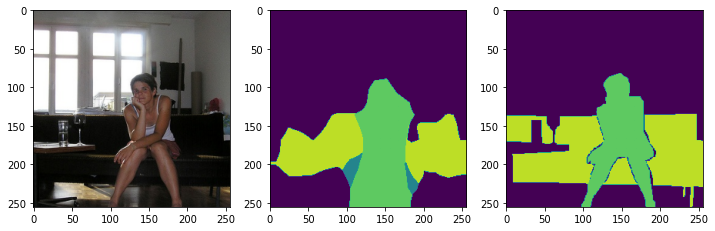

In [54]:
print('[15%,25%]')
quantile(0.15, 0.25)

[35%,45%]


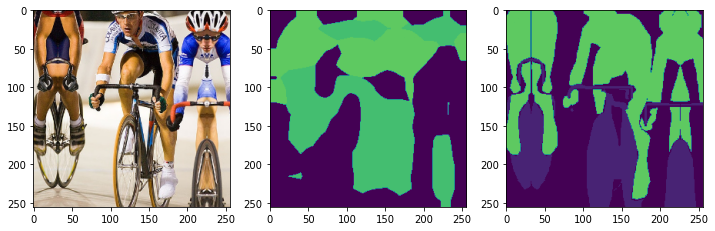

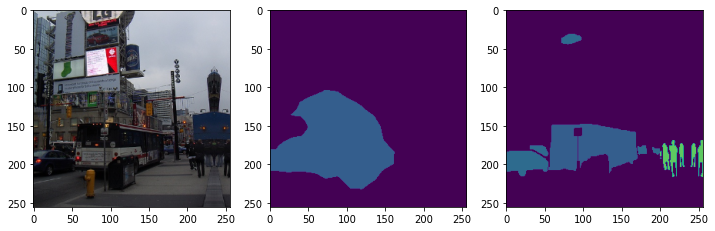

In [55]:
print('[35%,45%]')
quantile(0.35, 0.45)

In [56]:
torch.max(all_val_miou, dim = 0)

torch.return_types.max(values=tensor(1.0000, dtype=torch.float64), indices=tensor(112))

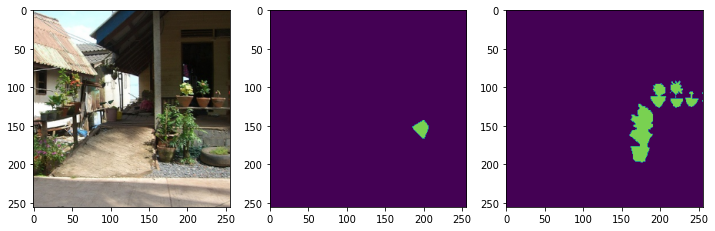

In [57]:
plot_images(112)

In [58]:
torch.where(all_val_miou > 0.9999999)

(tensor([112, 124, 329, 343, 363, 615, 719, 727, 900, 909]),)

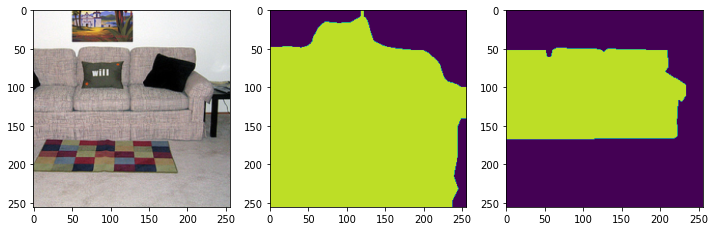

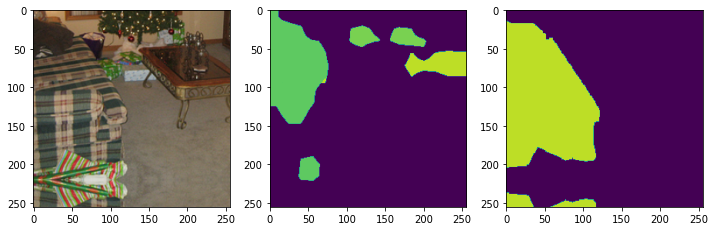

In [59]:
plot_images(329)
plot_images(900)

In [69]:
ios = []
model.eval()
for img,lbl in test_dataloader:
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    predict = predict.cpu().detach().numpy()
    lbl = lbl.cpu().detach().numpy()
    ios += [compute_iou(predict, lbl)]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [70]:
a = np.array(ios, dtype=object)

In [71]:
a[0].shape, len(a)

((8, 21), 182)

In [72]:
b = []
for i in a:
    b.extend(i)
len(b)

1449

In [73]:
pd.DataFrame(b, columns=VOC_CLASSES)

,background,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,...,diningtable,dog,horse,motorbike,person,potted plant,sheep,sofa,train,tv/monitor
0,0.363281,0.363281,0.367187,0.367187,0.367187,0.367187,0.367187,0.367187,0.367187,0.367187,...,0.371094,0.371094,0.371094,0.375000,0.375000,0.375000,0.375000,0.375000,0.378906,0.378906
1,0.953125,0.945312,0.929687,0.921875,0.914062,0.906250,0.902344,0.898437,0.894531,0.894531,...,0.890625,0.886719,0.882812,0.878906,0.859375,0.851562,0.847656,0.847656,0.828125,0.820312
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,0.996094,0.921875,0.871094,0.804687,0.722656,0.722656,...,0.867187,0.988281,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1445,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1446,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1447,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
